In [2]:
import numpy as np
from sklearn.impute import SimpleImputer
import sys
sys.path.append("..")
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
from scipy import optimize
from torch.utils.data import DataLoader, Dataset
import missing_process.missing_method as missing_method
from missing_process.block_rules import *
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


In [13]:
real_datalist = ["banknote","concrete_compression",
            "wine_quality_white","wine_quality_red",
            "california","climate_model_crashes",
            "connectionist_bench_sonar","qsar_biodegradation",
            "yeast","yacht_hydrodynamics"
            ]
#real_datalist = ["yacht_hydrodynamics"]

syn_datalist = ["syn1"]


missingtypelist = ["quantile","diffuse","logistic"]
missingtypelist = ["diffuse"]

In [4]:
def load_train_test(dataname,missingtype,rule_name,seed = 1):  
            
    directory_path = f"../datasets/{dataname}"  
    # Opening JSON file
    f = open(f'{directory_path}/split_index_seed-{seed}.json')
    data = json.load(f)

    train_index = data["train_index"]
    test_index = data["test_index"]

    norm_values = np.load(f'{directory_path}/{dataname}_norm.npy')
    observed_masks = np.load(f'{directory_path}/{missingtype}/{rule_name}.npy')

    train_values = norm_values[train_index,:]

    train_masks = observed_masks[train_index,:]

    test_values = norm_values[test_index,:]

    test_masks = observed_masks[test_index,:]

    return train_values,train_masks,test_values,test_masks
    

In [5]:
def load_train_test(index_file,missingtype,rule_name,directory_path,dataname):  


    
    train_index = index_file["train_index"]
    test_index = index_file["test_index"]

    norm_values = np.load(f'{directory_path}/{dataname}_norm.npy')
    observed_masks = np.load(f'{directory_path}/{missingtype}/{rule_name}.npy')

    train_values = norm_values[train_index,:]

    train_masks = observed_masks[train_index,:]

    test_values = norm_values[test_index,:]

    test_masks = observed_masks[test_index,:]

    return train_values,train_masks,test_values,test_masks

In [38]:
def mean_imp(missingtypelist,datalist_name,seed = 1,nfold = 5):


    if datalist_name == "real":
        datalist = real_datalist
    elif datalist_name == "syn":
        datalist = syn_datalist

    for missingtype in missingtypelist:
        print(missingtype)
        if missingtype == "logistic":
            missing_rule = load_json_file("missing_rate.json")
        elif missingtype == "diffuse":
            missing_rule = load_json_file("diffuse_ratio.json")
        elif missingtype == "quantile":
            missing_rule = load_json_file("quantile_full.json")



        for dataname in datalist:
            path = f"../impute/{missingtype}/{dataname}/mean"
            if not os.path.exists(path):
                # If the path does not exist, create it
                os.makedirs(path)

            for rule_name in missing_rule:

                    directory_path = f"../datasets/{dataname}"  
                    # Opening JSON file
                    f = open(f'{directory_path}/split_index_cv_seed-{seed}_nfold-{nfold}.json')
                    index_file = json.load(f)

                    for fold in index_file:

                        train_values,train_masks,test_values,test_masks = load_train_test(index_file[fold],missingtype,rule_name,directory_path,dataname)

                        train_values_na = np.where(train_masks == 0, np.nan, train_values)
                        test_values_na = np.where(test_masks == 0, np.nan, test_values)
                        
                        imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
                        imp_mean.fit(train_values_na)
                        test_imp = imp_mean.transform(test_values_na)
                        train_imp = imp_mean.transform(train_values_na)



                        rmse = RMSE(train_masks,train_values,train_imp)


                        if rmse > 0.5 :
                            print(rule_name)
                            make_plot(train_values,train_imp,title = "Compare")

                            return None
                    print()

                        # np.save(f'{path}/{rule_name}_seed-{seed}_{fold}_train.npy', train_imp.astype("float32"))
                        # np.save(f'{path}/{rule_name}_seed-{seed}_{fold}_test.npy', test_imp.astype("float32"))
            


            

diffuse



0.4


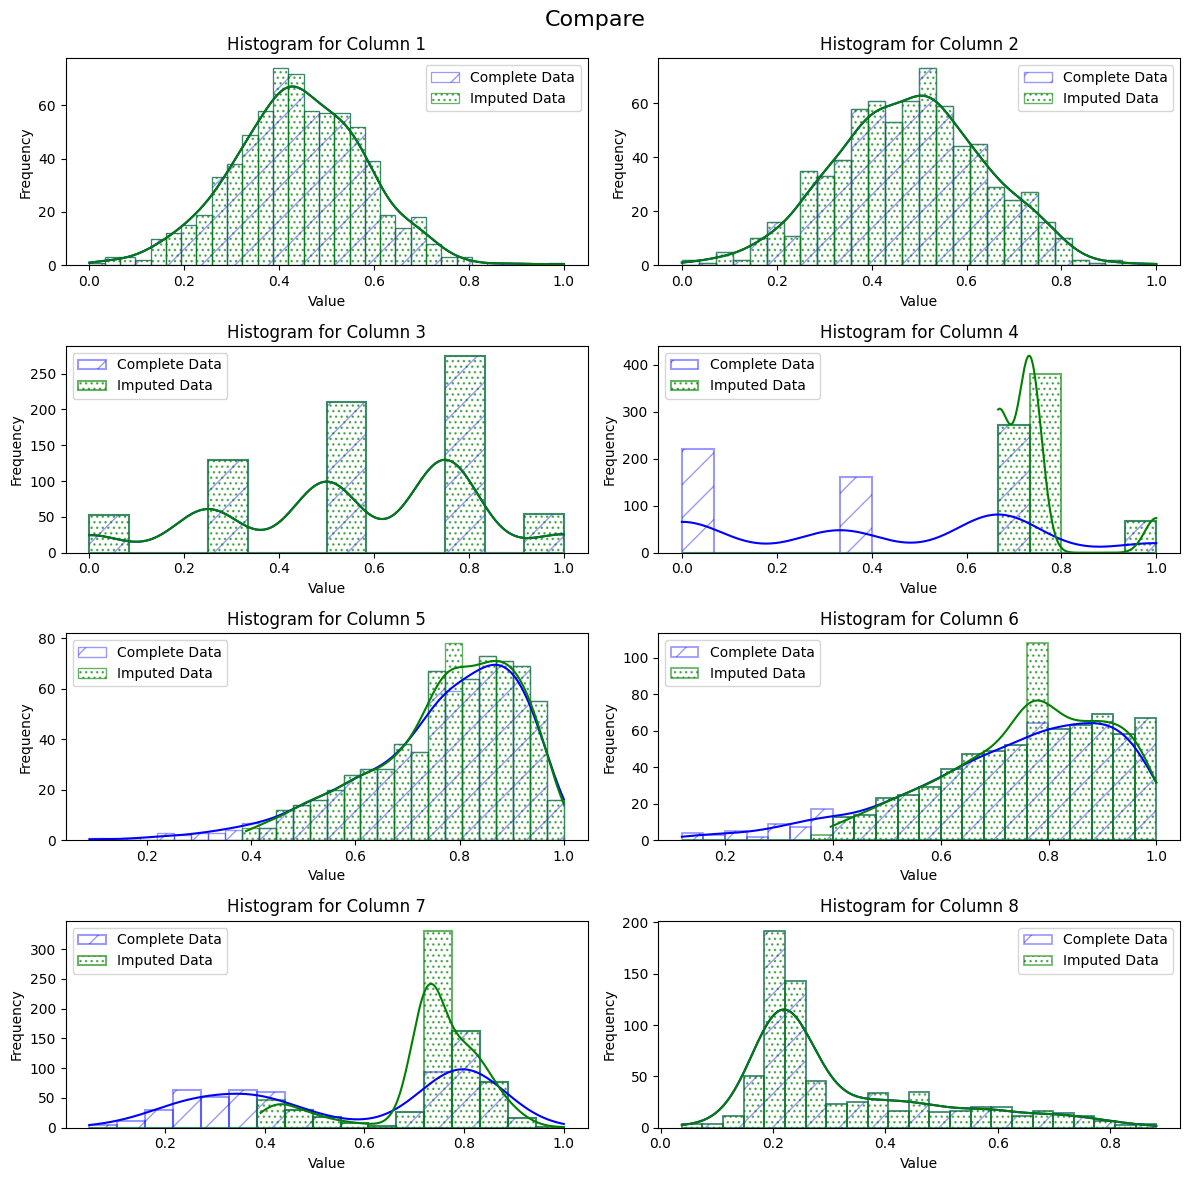

In [39]:
mean_imp(missingtypelist,"syn")

In [37]:
def make_plot(norm_value,mask, title = None):
        # Create a 4x2 grid of subplots
    fig, axes = plt.subplots(4, 2, figsize=(12, 12))
    axes = axes.ravel()  # Flatten the 4x2 grid for easy iteration
    masked_value = mask

    for i in range(norm_value.shape[1]):
        norm_column = norm_value[:, i]
        mask_column = masked_value[:, i]

        bins = np.histogram_bin_edges([norm_column, mask_column], bins='auto')
        #data_column2 = array_list[1][i]
        # Histogram
        #axes[i].hist(data_column, bins=30, alpha=0.7, edgecolor='black',kde = True)
        sns.histplot(data=norm_column, bins=bins, color='blue',alpha = 0.4, ax=axes[i], kde=True, label='Complete Data',
                     hatch="/", 
                     fill=False
                     )
        sns.histplot(data=mask_column, bins=bins, color='green',alpha = 0.6, ax=axes[i], kde=True, label='Imputed Data',
                     hatch='...', 
                     fill=False
                     )
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(f'Histogram for Column {i+1}')
        axes[i].legend()

    if title is not None:
        fig.suptitle(title, fontsize=16)
        # Adjust the layout
    plt.tight_layout()
    # plt.savefig(f"../plot/{title}.png")
    plt.show()

In [10]:
def RMSE(mask,complete,imputed):
    missing_data_points = mask == 0

    # Extracting the originally missing data from both complete and imputed data
    original_values = complete[missing_data_points]
    imputed_values = imputed[missing_data_points]

    # Calculating RMSE
    rmse = np.sqrt(np.mean((original_values - imputed_values) ** 2))

    return rmse